## Task.2 vars

In [1]:
## read the modules 
from covid19dh import covid19
import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt 
import seaborn as sns 
import dask.dataframe as dd
from plotnine import *
%matplotlib inline

In [2]:
## read the nuts classification 
nuts = pd.read_excel('01_Raw Data/NUTS2021.xlsx', sheet_name = "NUTS & SR 2021")
lau = pd.read_excel('01_Raw Data/EU-28_LAU_2016.xlsx')
shape = gpd.read_file('../01_GIS/02_Full file/Full shape/Full shape.shp')
shape

,NUTS_ID,geometry
0,BG423,"POLYGON ((24.42101 42.55306, 24.41032 42.46950..."
1,BG424,"POLYGON ((25.07422 41.79348, 25.05851 41.75177..."
2,BG425,"POLYGON ((25.94863 41.32034, 25.90644 41.30757..."
3,CH011,"MULTIPOLYGON (((6.86623 46.90929, 6.89621 46.9..."
4,CH012,"POLYGON ((8.47767 46.52760, 8.39953 46.48872, ..."
...,...,...
2334,Viana do Castelo,"POLYGON ((-8.21044 41.92318, -8.21053 41.92271..."
2335,Vila Real,"POLYGON ((-7.83576 41.15351, -7.83615 41.15360..."
2336,Viseu,"POLYGON ((-7.75405 40.52696, -7.75553 40.52694..."
2337,Évora,"POLYGON ((-7.45825 38.22493, -7.45934 38.22272..."


##  1. COVID-19 DATA-HUB

In [ ]:
!pip install --upgrade covid19dh

In [3]:
eu_codes = """Code	Country	Alpha-2	Alpha-3
040	Austria	AT	AUT
056	Belgium	BE	BEL
100	Bulgaria	BG	BGR
191	Croatia	HR	HRV
196	Cyprus	CY	CYP
203	Czech Republic	CZ	CZE
208	Denmark	DK	DNK
233	Estonia	EE	EST
246	Finland	FI	FIN
250	France	FR	FRA
276	Germany	DE	DEU
300	Greece	GR	GRC
348	Hungary	HU	HUN
372	Ireland, Republic of (EIRE)	IE	IRL
380	Italy	IT	ITA
428	Latvia	LV	LVA
440	Lithuania	LT	LTU
442	Luxembourg	LU	LUX
470	Malta	MT	MLT
528	Netherlands	NL	NLD
616	Poland	PL	POL
620	Portugal	PT	PRT
642	Romania	RO	ROU
703	Slovakia	SK	SVK
705	Slovenia	SI	SVN
724	Spain	ES	ESP
752	Sweden	SE	SWE
826	United Kingdom	GB	GBR"""

In [4]:
eu_codes = pd.DataFrame([i.split('\t') for i in eu_codes.split('\n')]).iloc[1:,:]
eu_codes.drop(columns = 0, inplace= True)
eu_codes.columns = ['country', 'iso2', 'iso3']
add = pd.DataFrame({'country': ['Norway', 'Switzerland','Iceland'],
                    'iso2' : ['NO', 'CH','IS'],
                    'iso3' : ['NOR', 'CHE' ,'ISE']})
eu_codes = pd.concat([eu_codes, add], axis = 0, ignore_index = True)
eu_codes

,country,iso2,iso3
0,Austria,AT,AUT
1,Belgium,BE,BEL
2,Bulgaria,BG,BGR
3,Croatia,HR,HRV
4,Cyprus,CY,CYP
5,Czech Republic,CZ,CZE
6,Denmark,DK,DNK
7,Estonia,EE,EST
8,Finland,FI,FIN
9,France,FR,FRA


In [ ]:
x, src = covid19(eu_codes[3], level = 1, verbose = False)

In [ ]:
print('Available countries are:')
print(len(eu_codes[eu_codes[3].isin(src.iso_alpha_3.unique())]))
print()
eu_codes[eu_codes[3].isin(src.iso_alpha_3.unique())]

In [ ]:
for i in eu_codes[eu_codes[3].isin(src.iso_alpha_3.unique())][3]:
    x.query(f'iso_alpha_3 == "{i}"').groupby(
    ['date', 'administrative_area_level_1'])['vaccines'].sum().plot(
    x = 'date', y = 'vaccines', 
    legend = False, figsize = (8,5)) 
    plt.title(f'{i}')
    plt.show()

In [ ]:
for i in eu_codes[eu_codes[3].isin(src.iso_alpha_3.unique())][3]:
    print(i, '\n')
    print(x.query(f'iso_alpha_3 == "{i}"')[['date', 'vaccines']] \
    .dropna(subset = ['vaccines']))

## 2. Google mobility data 

Notes from google team to keep in mind while interepresting the data. 

**"Location accuracy and the understanding of categorized places varies from region to region, so we don’t recommend using this data to compare changes between countries, or between regions with different characteristics (e.g. rural versus urban areas)."**

[Google mobility data](https://www.google.com/covid19/mobility/) are downloaded on **22-12-2021**. 

In [26]:
gog = dd.read_csv('01_Raw Data/Google Mobility Data/*.csv', dtype={'grocery_and_pharmacy_percent_change_from_baseline': 'float64',
       'iso_3166_2_code': 'object', 'sub_region_2': 'object',
       'parks_percent_change_from_baseline': 'float64',
       'residential_percent_change_from_baseline': 'float64',
       'retail_and_recreation_percent_change_from_baseline': 'float64',
       'sub_region_1': 'object',
       'transit_stations_percent_change_from_baseline': 'float64',
       'workplaces_percent_change_from_baseline': 'float64','metro_area': 'object'})
gog_eu = gog[gog['country_region_code'].isin(eu_codes.iso2.unique())].compute()
gog_eu.rename(columns={'sub_region_1': 'state',
                        'sub_region_2': 'county',
                        'country_region_code' : 'iso2', 
                         'country_region': 'country',
                        'retail_and_recreation_percent_change_from_baseline': 'retail',
                        'grocery_and_pharmacy_percent_change_from_baseline': 'grocery',
                        'parks_percent_change_from_baseline': 'parks',
                        'transit_stations_percent_change_from_baseline': 'transit',
                        'workplaces_percent_change_from_baseline': 'workplaces',
                        'residential_percent_change_from_baseline': 'residential'}, inplace = True)
gog_eu.drop(['iso_3166_2_code', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'metro_area'], axis = 1, inplace = True)
gog_eu['date'] = pd.to_datetime(gog_eu['date'])
gog_eu.dropna(subset=['country', 'state'], inplace = True) # not by county, some NUTS2 levels don't have countries i.g. Vienna (Austria) 
gog_eu.drop('county', axis =1, inplace = True)
gog_eu = gog_eu.groupby(['iso2', 'country', 'state', 'date']).mean().reset_index().drop('iso2', axis =1)
gog_eu.rename({"state": "region"}, axis =1, inplace = True)
gog_eu.head(3)

,country,region,date,retail,grocery,parks,transit,workplaces,residential
0,Austria,Burgenland,2020-02-15,1.333333,-2.00,57.0,10.250000,-6.000000,-2.0
1,Austria,Burgenland,2020-02-16,12.750000,NaN,47.0,11.333333,2.000000,-1.0
2,Austria,Burgenland,2020-02-17,9.000000,5.75,24.0,12.142857,3.111111,-1.5


In [29]:
# read the google's index
gog_id = pd.read_excel('01_Raw Data/index_gog.xlsx').drop('country', axis =1)
# merge the data 
gog_mob = pd.merge(gog_id, gog_eu, on = 'region')
gog_mob =  gog_mob.groupby(gog_mob.iloc[:, :6].columns.tolist()).mean().reset_index()
gog_mob = pd.merge(shape, gog_mob, left_on = 'NUTS_ID', right_on = 'nuts_id').drop('nuts_id', axis = 1)
gog_mob.drop('geometry', axis = 1, inplace = True)
gog_mob.head(3)

,NUTS_ID,region,country,date,retail,grocery,parks,transit,workplaces,residential
0,BG423,Pazardzhik,Bulgaria,2020-02-15,-4.666667,1.666667,-18.333333,NaN,-2.000000,1.0
1,BG423,Pazardzhik,Bulgaria,2020-02-16,15.500000,6.666667,58.000000,NaN,3.333333,-2.0
2,BG423,Pazardzhik,Bulgaria,2020-02-17,-1.000000,3.333333,15.666667,NaN,4.333333,-1.5


In [ ]:
# Export the id columns to be filled by the nuts_id 
# gog_eu.iloc[:,:2].drop_duplicates(subset = ['region']).to_excel('01_Raw Data/gog_index.xlsx', index = False)

## 3. Appel mobility data 



[Appel Mobility Data](https://covid19.apple.com/mobility) are downloaded on **22-12-2021**.

In [30]:
apl = pd.read_csv('01_Raw Data/Appel Mobility Data/applemobilitytrends-2021-12-20.csv', sep = ',', low_memory = False)
apl.drop('alternative_name', axis = 1, inplace = True)
apl = apl[apl['country'].notna()]
apl = apl.query('geo_type != "city"').drop(['sub-region', 'geo_type'], axis =1)
apl_eu = apl[apl['country'].isin(eu_codes.country.unique())]
apl_eu = apl_eu.melt(id_vars = ['region', 'country', 'transportation_type'], var_name = "date")
apl_eu = apl_eu.pivot(index = ['region', 'country', 'date'], columns = 'transportation_type', values = 'value').reset_index()
apl_eu['date'] = pd.to_datetime(apl_eu['date'])
apl_eu.reset_index(drop = True, inplace = True)
# read the Apple's id 
apl_id = pd.read_excel('01_Raw Data/index_apl.xlsx').drop('country', axis = 1)
# merge the datasets
apl_mob = pd.merge(apl_id, apl_eu, on = 'region')
apl_mob = pd.merge(shape, apl_mob, on = 'NUTS_ID')
apl_mob.drop('geometry', axis = 1, inplace = True)
apl_mob.head(3)

,NUTS_ID,region,country,date,driving,transit,walking
0,CH011,Canton of Vaud,Switzerland,2020-01-13,100.00,100.00,100.00
1,CH011,Canton of Vaud,Switzerland,2020-01-14,106.86,107.80,106.78
2,CH011,Canton of Vaud,Switzerland,2020-01-15,104.54,103.75,108.65


In [ ]:
# Export the id columns to be filled by the nuts_id 
# aplid = apl_eu.iloc[:,:2].drop_duplicates(subset = ['region']).sort_values(by = "country")
# aplid = aplid[['country', 'region']]
# aplid.to_excel('01_Raw Data/apl_index.xlsx', index = False)

## 4. harmonizing Appel & Google data 

In [45]:
mob_data.columns

Index(['NUTS_ID', 'date', 'retail', 'grocery', 'parks', 'transit_x',
       'workplaces', 'residential', 'region', 'country', 'driving',
       'transit_y', 'walking'],
      dtype='object')

In [48]:
mob_data = pd.merge(gog_mob, apl_mob, on = ['NUTS_ID', 'date'])
mob_data.drop(['region_x', 'country_x'], axis = 1, inplace = True)
mob_data.rename(columns = {'region_y': 'region', 'country_y': 'country'}, inplace = True)
mob_data = mob_data[['country','region', 'NUTS_ID', 'date', 'retail', 'grocery', 'parks', 'transit_x',
       'workplaces', 'residential', 'driving','transit_y', 'walking']]
mob_data.head(3)

,country,region,NUTS_ID,date,retail,grocery,parks,transit_x,workplaces,residential,driving,transit_y,walking
0,Switzerland,Canton of Vaud,CH011,2020-02-15,-3.0,-3.0,33.0,6.0,-5.0,-1.0,154.67,92.92,121.66
1,Switzerland,Canton of Vaud,CH011,2020-02-16,13.0,6.0,24.0,10.0,-6.0,-1.0,102.89,99.97,81.25
2,Switzerland,Canton of Vaud,CH011,2020-02-17,-8.0,-11.0,-19.0,-11.0,-16.0,3.0,103.45,105.74,93.94


In [91]:
mob_data.to_excel('02_Cleaned Data/Mobility data (Google + Apple).xlsx', index = False)

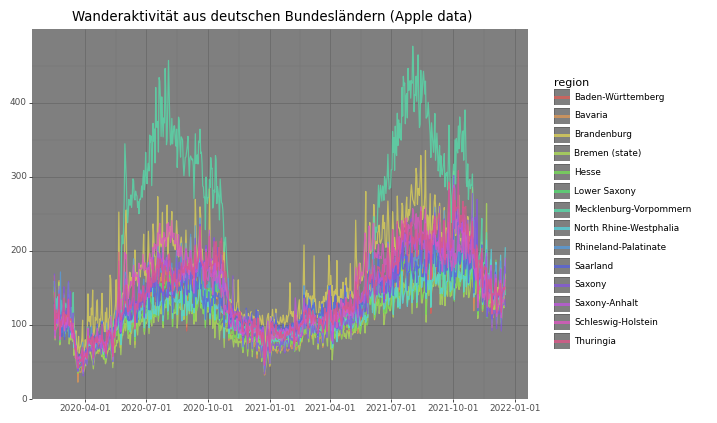

<ggplot: (103907216951)>

In [90]:
# export the mobility data 
(ggplot(mob_data.query('country == "Germany"')[['region', 'date', 'walking']],
        aes( x = 'date', y = 'walking', color = 'region'))
    + theme_dark(base_size = 8)
    + geom_line(alpha = .8)
    # + geom_smooth(method = 'lm', alpha = .1)
    + labs(x = '', y = '', title = 'Wanderaktivität aus deutschen Bundesländern (Apple data)'))